In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import scipy.signal as sgn
from scipy.optimize import minimize
from matplotlib.patches import Rectangle
from mpl_toolkits import mplot3d
import torch
# %matplotlib inline
# %matplotlib ipympl
# %matplotlib ipympl

In [3]:
def center_fn(led_pos: tuple, kcx: torch.tensor=torch.tensor([1.0859473, -0.000556592144, 5.48586221e-07]), kcy: torch.tensor=torch.tensor([1.09006337, -0.000365032841, 4.51764466e-07]), 
              origin: torch.tensor=torch.tensor((2758, 1219)), unit: torch.tensor=torch.tensor((202, 186)), center_led: torch.tensor=torch.tensor((15, 15))):

    rx, ry = (led_pos[0] - center_led[0])*unit[0], (30 - led_pos[1] - center_led[1])*unit[1]
    r = torch.sqrt(rx**2 + ry**2)
    r_arr = torch.pow(r, torch.arange(3))
    
    x_est = rx*sum(kcx*r_arr) + origin[0]
    y_est = ry*sum(kcy*r_arr) + origin[1]

    return (x_est, y_est)

In [4]:
def axis_min_fn(led_pos: tuple, kax0: torch.tensor=torch.tensor([2499.64063531, 0.18209488, 0.03107323, 2.88452691, -0.03847153, -0.02654681, -0.12702866, -0.02022648])):
    x1, y1 = led_pos
    return kax0[1]*x1 + kax0[2]*y1 + kax0[3]*(x1**2) + kax0[4]*(y1**2) + kax0[5]*x1*y1 + kax0[6]*(x1**3) + kax0[7]*(y1**3) + kax0[0]

def axis_max_fn(led_pos: tuple, kax1: torch.tensor=torch.tensor([2765.55044151, -6.83235681, -4.38549775, 0.02671118, 0.02110941, 0.28043923])):
    x1, y1 = led_pos
    return kax1[1]*x1 + kax1[2]*y1 + kax1[3]*x1**2 + kax1[4]*y1**2 + kax1[5]*x1*y1 + kax1[0]

In [5]:
def angle_fn(led_pos: tuple, kang: torch.tensor=torch.tensor([-93.08141194626909, 9.42944697, 1.31815639, 0.47404313, 0.33433636, -0.74189097])):
    x1, y1 = led_pos
    ang = kang[1]*x1 + kang[2]*y1 + kang[3]*x1**2 + kang[4]*y1**2 + kang[5]*x1*y1 + kang[0]
    return ang/180*3.14

In [6]:
def find_ellipse_params_from_extrap_fns(led_pos, 
                                        kcx: torch.tensor=torch.tensor([1.0859473, -0.000556592144, 5.48586221e-07]), 
                                        kcy: torch.tensor=torch.tensor([1.09006337, -0.000365032841, 4.51764466e-07]), 
                                        origin: torch.tensor=torch.tensor((2758, 1219)), unit: torch.tensor=torch.tensor((202, 186)),
                                        kax0: torch.tensor=torch.tensor([2499.64063531, 0.18209488, 0.03107323, 2.88452691, -0.03847153, -0.02654681, -0.12702866, -0.02022648]), 
                                        kax1: torch.tensor=torch.tensor([2765.55044151, -6.83235681, -4.38549775, 0.02671118, 0.02110941, 0.28043923]), 
                                        kang: torch.tensor=torch.tensor([-93.08141194626909, 9.42944697, 1.31815639, 0.47404313, 0.33433636, -0.74189097]),
                                        more_vars=False):
    
    if more_vars:
        a = axis_max_fn_2(led_pos, kax1)
        b = axis_min_fn_2(led_pos, kax0)
        theta = angle_fn_2(led_pos, kang)
        cx, cy = center_fn(led_pos, kcx, kcy, origin, unit)
    else:
        a = axis_max_fn(led_pos, kax1)
        b = axis_min_fn(led_pos, kax0)
        theta = angle_fn(led_pos, kang)
        cx, cy = center_fn(led_pos, kcx, kcy, origin, unit)

    A = (b**2)*torch.cos(theta)**2 + (a**2)*torch.sin(theta)**2
    B = (b**2 - a**2)*torch.sin(2*theta)
    C = (b**2)*torch.sin(theta)**2 + (a**2)*torch.cos(theta)**2
    D = -(2*A*cx + B*cy)
    E = -(2*C*cy + B*cx)
    F = A*cx**2 + C*cy**2 + B*cx*cy - (a**2)*(b**2)

    return ((a, b), (cx, cy), theta), (A, B, C, D, E, F)

In [7]:
def contour_points_v3(g_img, tot_pts=500):

    kernel = np.ones((15, 15), np.uint8)
    gradient = cv2.morphologyEx(g_img, cv2.MORPH_GRADIENT, kernel)
    
    blur = cv2.GaussianBlur(gradient + 20, (5, 5), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    gradient_img = np.zeros_like(g_img, dtype=np.uint8)

    contours, _ = cv2.findContours(th3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) < 1:
        return None
    
    cv2.drawContours(gradient_img, contours, -1, 255, 2)

    kernel = np.ones((25, 25),np.uint8)
    gradient_img = cv2.dilate(gradient_img, kernel, iterations = 1)    


    hull_img = np.zeros_like(g_img, dtype=np.uint8)

    blur = cv2.GaussianBlur(g_img, (3, 3), 0)
    ret3, th3 = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    contours, _ = cv2.findContours(th3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) < 1:
        return None
    
    area_cntrs = [cv2.contourArea(cnt) for cnt in contours]
    max_cntr_index = np.argmax(area_cntrs)
    cnt = contours[max_cntr_index]

    hull = cv2.convexHull(cnt)
    cv2.drawContours(hull_img, [hull], 0, 125, 2)

    op = np.logical_and(gradient_img, hull_img).astype(np.uint8)*255

    x, y = np.where(op > 1)
    points = np.vstack([y, x]).T
        
    if points.shape[0] > tot_pts:
        points = np.take(points, list(set(np.random.randint(0, points.shape[0], size=tot_pts))), axis=0)

    return points

In [8]:
def find_x(point, EllipseParams):

    y1 = point[1]
    A, B, C, D, E, F = EllipseParams
    bb = (B*y1 + D)/A
    cc = (C*y1**2 + E*y1 + F)/A

    temp = bb**2 - 4*cc

    garbage = torch.tensor(-8000.1, dtype=torch.float32, requires_grad=True)
    if temp > 0:
        x1, x2 = (-1*bb + torch.sqrt(temp))/2, (-1*bb - torch.sqrt(temp))/2
        return x1, x2
    elif temp == 0:
        x1, x2 = (-1*bb + torch.sqrt(temp))/2, (-1*bb - torch.sqrt(temp))/2
        return x1, x1-8000
    else:
        return garbage, garbage-1000

In [9]:
def find_all_x(points, Ellipseparams):
    # xs = map(find_x, points.T, np.repeat(Ellipseparams, len(points.T), axis=0))
    xs = torch.zeros([len(points), 2])
    for i, point in enumerate(points):
        x1, x2 = find_x(point, Ellipseparams)
        xs[i, 0] = x1
        xs[i, 1] = x2
    
    return xs

In [10]:
def target_points(points, extrap_points, max_dist):
    # extrap points are only 2 x cords
    x_points = torch.tensor(points[:, 0]).repeat(2, 1).T
    diff = torch.abs(x_points - extrap_points)
    cords = torch.argwhere(diff < max_dist)
    retain_points = points[cords[:, 0].unique(), :]

    return retain_points

In [11]:
def loss_img(points, extrap_points, loss_type=2):
    """
    ellipse: img with ellipse drawn on zeros
    points: all points detected by boundary method

    returns avg l2 loss for one image
    """

    x_points = points[:, 0].repeat(2, 1).T
    diff = torch.abs(x_points - extrap_points)
    
    # cords = torch.argwhere(diff < max_dist)
    loss = ((diff[range(diff.shape[0]), torch.argmin(diff, axis=1)])**loss_type).sum()
    # loss = torch.sum(diff[cords[:, 0], cords[:, 1]])
    # loss = sum([diff[x[0], x[1]] for x in cords])

    if diff.shape[0] > 0:
        loss /= diff.shape[0]
        # print(diff.shape[0]) # different for different led positions

    return loss

In [12]:
#  tensor([[ 1.0859e+00, -5.5658e-04,  5.2995e-07],
#          [ 1.0901e+00, -3.6503e-04,  4.5244e-07]], dtype=torch.float64),
#  tensor([2758.0230, 1218.9767], dtype=torch.float64),
#  tensor([[ 2.4996e+03,  1.8464e-01,  3.6049e-02,  2.8864e+00, -3.2558e-02,
#           -2.2786e-02, -1.2529e-01, -1.3723e-02,  0.0000e+00,  0.0000e+00],
#          [ 2.7655e+03, -6.8554e+00, -4.4086e+00,  3.6593e-03, -2.1213e-03,
#            2.5728e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
#          [-9.3076e+01,  9.4267e+00,  1.3283e+00,  4.6477e-01,  3.4690e-01,
#           -7.3758e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]]

In [13]:
OPT_PARAMS_CXY_COEFFS = torch.tensor((
    (
        1.0859e+00, -5.5658e-04, 5.2995e-07
    ),
    (
        1.0901e+00, -3.6503e-04, 4.5244e-07
    )

))

OPT_PARAMS_CXY_BIAS = torch.tensor((
    2758.0230, 1218.9767
))

# (MINOR, MAJOR)
OPT_PARAMS_AXIS= torch.tensor((
    (
        2.4996e+03, 1.8464e-01, 3.6049e-02, 2.8864e+00, -3.2558e-02, 
        -2.2786e-02, -1.2529e-01, -1.3723e-02, 0.0000e+00, 0.0000e+00
    ), 
    (
        2.7655e+03, -6.8554e+00, -4.4086e+00, 3.6593e-03, -2.1213e-03, 
        2.5728e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00
    )    
))

OPT_PARAMS_ANGLES = torch.tensor((
    -9.3076e+01, 9.4267e+00, 1.3283e+00, 4.6477e-01, 3.4690e-01,
    -7.3758e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00
))


In [14]:
tot_num_pnts = 2000 # sample max these number from boundary/contour of image
max_dist_allowed = 100 # |boundary of image - point on ellipse from functions| < 150, only these contour points considered

target_points_array = torch.zeros([11, 11, tot_num_pnts, 2])
targets_len = np.zeros([11, 11]) # store total number of samples for each led location
for x in range(10, 21):
    for y in range(10, 21):

        dir_path = "Z:/CSE\CSE-Research/Microscopy3D/CV_CSE_Collaboration/Results/CV_CSE/fpm_capture/output/2023_03_15/2023_03_15_16_02_07/"
        file_path = f"2023_03_15_16_02_07_img_shutter_05_x_{x}_y_{y}_r_0_g_1_b_0.tiff"
        
        img = cv2.imread(dir_path + file_path, cv2.IMREAD_UNCHANGED)
        _, g_img, _ = cv2.split(img)

        img_8 = cv2.convertScaleAbs(img, alpha=(255/65535))
        g_img_8 = cv2.convertScaleAbs(g_img, alpha=(255/65535))
        points = contour_points_v3(g_img_8, tot_pts=tot_num_pnts) # extract points from given full-sized tiff image

        _, EllipseParams = find_ellipse_params_from_extrap_fns((x, y), more_vars=False) # find A, B, C, D, E and F -> Ellipse Parameters -> Implicit Equation
        extrap_points = find_all_x(points, EllipseParams) # for all y cords in points, find possible corresponding 2 x cords given by the ellipse estimated through functions
        targets = target_points(points, extrap_points, max_dist_allowed) # keep only points that are < max_dist_allowed away from function estimated ellipse on the x-axis
        target_points_array[x-10, y-10, :targets.shape[0], :] = torch.tensor(targets)
        targets_len[x-10, y-10] = targets.shape[0]

In [15]:
losses = np.zeros([11, 11])
for x in range(10, 21):
    for y in range(10, 21):

        dir_path = "Z:/CSE\CSE-Research/Microscopy3D/CV_CSE_Collaboration/Results/CV_CSE/fpm_capture/output/2023_03_15/2023_03_15_16_02_07/"
        file_path = f"2023_03_15_16_02_07_img_shutter_05_x_{x}_y_{y}_r_0_g_1_b_0.tiff"

        points = target_points_array[x-10, y-10, :int(targets_len[x-10, y-10]), :]

        _, EllipseParams = find_ellipse_params_from_extrap_fns((x, y))
        losses[x-10, y-10] = loss_img(points, find_all_x(points, EllipseParams), loss_type=1).numpy()
        if losses[x-10, y-10] == 0.:
            losses[x-10, y-10] = np.nan

print(sum(losses[targets_len.nonzero()]))

losses_2 = np.zeros([11, 11])
for x in range(10, 21):
    for y in range(10, 21):

        dir_path = "Z:/CSE\CSE-Research/Microscopy3D/CV_CSE_Collaboration/Results/CV_CSE/fpm_capture/output/2023_03_15/2023_03_15_16_02_07/"
        file_path = f"2023_03_15_16_02_07_img_shutter_05_x_{x}_y_{y}_r_0_g_1_b_0.tiff"

        points = target_points_array[x-10, y-10, :int(targets_len[x-10, y-10]), :]

        # _, EllipseParams = find_ellipse_params_from_extrap_fns((x, y))
        # _, EllipseParams = find_ellipse_params_from_extrap_fns((x, y), kcx, kcy, kax0, kax1, kang)
        _, EllipseParams = find_ellipse_params_from_extrap_fns((x, y), OPT_PARAMS_CXY_COEFFS[0], OPT_PARAMS_CXY_COEFFS[1], OPT_PARAMS_CXY_BIAS, [202, 186],
                                                                OPT_PARAMS_AXIS[0], OPT_PARAMS_AXIS[1], OPT_PARAMS_ANGLES, more_vars=False)
        losses_2[x-10, y-10] = loss_img(points, find_all_x(points, EllipseParams), loss_type=1).detach().numpy()

        if losses_2[x-10, y-10] == 0.:
            losses_2[x-10, y-10] = np.nan

print(sum(losses_2[targets_len.nonzero()]))

3303.3148379325867
2718.436550140381


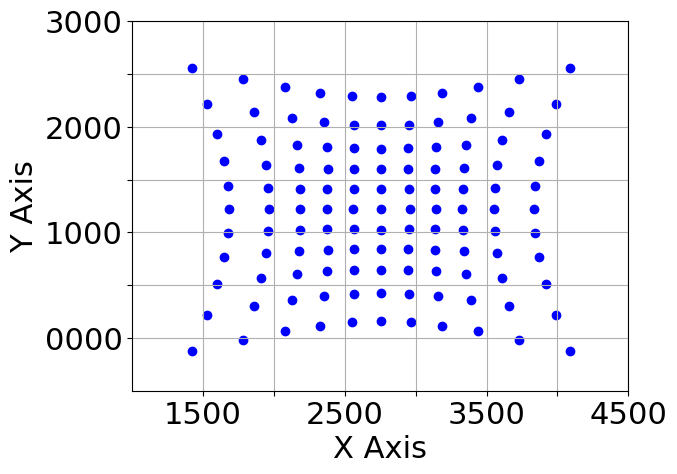

In [16]:
plt.rcParams.update({'font.size': 22})

xticks = np.linspace(1500, 4500, 7)
xticklabels = ['1500', '', '2500', '', '3500', '', '4500']

yticks = np.linspace(0, 3000, 7)
yticklabels = ['0000', '', '1000', '', '2000', '', '3000']

new_cnts = np.zeros([11, 11, 2])

for x in range(10, 21):
    for y in range(10, 21):
        x_est, y_est = center_fn(
            led_pos=(x, y), 
            kcx=OPT_PARAMS_CXY_COEFFS[0], 
            kcy=OPT_PARAMS_CXY_COEFFS[1], 
            origin=OPT_PARAMS_CXY_BIAS
            )
        new_cnts[x-10, y-10] = x_est.numpy(), y_est.numpy()

plt.figure()
plt.scatter(new_cnts[:, :, 0], new_cnts[:, :, 1], color='blue', label='new_fn')
plt.xlabel('X Axis')
plt.ylabel('Y Axis')

# plt.title('Center Coordinates (Px)')
# plt.legend()

plt.xlim(1000, 4500)
plt.xticks(xticks, xticklabels)

plt.ylim(-500, 3000)
plt.yticks(yticks, yticklabels)

plt.grid()
plt.show()


In [17]:
np.linspace(2500, 2700, 9)

array([2500., 2525., 2550., 2575., 2600., 2625., 2650., 2675., 2700.])

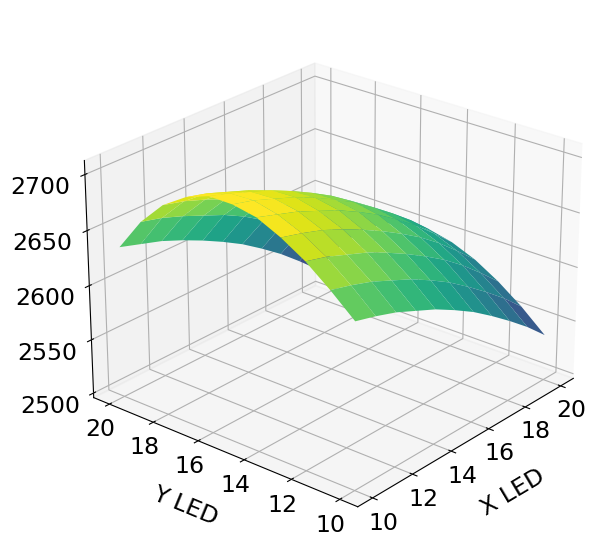

In [18]:
plt.rcParams.update({'font.size': 17})

xticks = np.linspace(10, 20, 6)
yticks = np.linspace(10, 20, 6)
zticks = np.linspace(2500, 2700, 5)

axis_lens_opt = np.zeros([11, 11, 2])

for x in range(10, 21):
    for y in range(10, 21):
        axis_lens_opt[x-10, y-10, 0] = int(axis_min_fn((x, y), OPT_PARAMS_AXIS[0]).numpy())
        axis_lens_opt[x-10, y-10, 1] = int(axis_max_fn((x, y), OPT_PARAMS_AXIS[1]).numpy())


axis_lens_opt = np.array([list((axis_lens_opt[i, :])) for i in range(axis_lens_opt.shape[0])]).T
xx, yy = np.meshgrid([i for i in range(10, 21)], [i for i in range(10, 21)])

# plt.figaspect(0.5)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')

cp = ax.plot_surface(yy, xx, axis_lens_opt[0, :, :], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', vmax=2700, vmin=2500)
# ax.set_title('Minor Axis Lengths');
ax.set_xlabel('X LED')
ax.set_ylabel('Y LED');
ax.set_zticks(zticks)
ax.view_init(25, -140)


ax.set_xlabel('X LED', labelpad=10)
ax.set_ylabel('Y LED', labelpad=10)
# ax.set_zlabel('Length', labelpad=20)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_zticks(zticks)

ax.tick_params(axis='z', which='major', pad=10)
ax.tick_params(axis='x', which='major', pad=0)
ax.tick_params(axis='y', which='major', pad=0)

# fig.colorbar(cp, fraction=0.04, pad=0.04)
# plt.tight_layout()

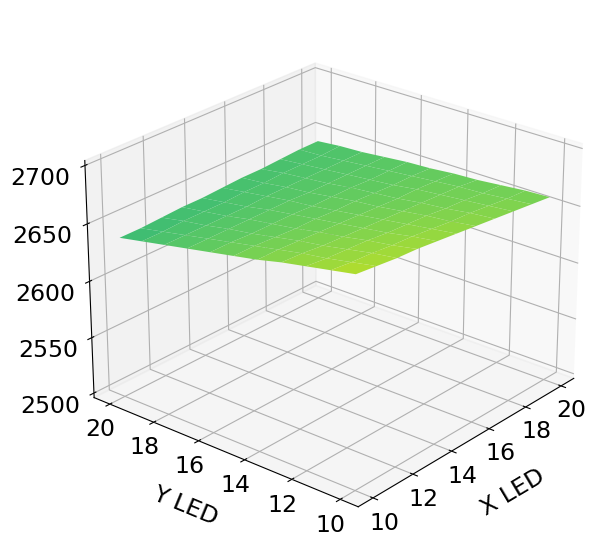

In [19]:
plt.rcParams.update({'font.size': 17})

xticks = np.linspace(10, 20, 6)
yticks = np.linspace(10, 20, 6)
zticks = np.linspace(2500, 2700, 5)

axis_lens_opt = np.zeros([11, 11, 2])

for x in range(10, 21):
    for y in range(10, 21):
        axis_lens_opt[x-10, y-10, 0] = int(axis_min_fn((x, y), OPT_PARAMS_AXIS[0]).numpy())
        axis_lens_opt[x-10, y-10, 1] = int(axis_max_fn((x, y), OPT_PARAMS_AXIS[1]).numpy())


axis_lens_opt = np.array([list((axis_lens_opt[i, :])) for i in range(axis_lens_opt.shape[0])]).T
xx, yy = np.meshgrid([i for i in range(10, 21)], [i for i in range(10, 21)])

# plt.figaspect(0.5)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')

cp = ax.plot_surface(yy, xx, axis_lens_opt[1, :, :], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', vmax=2700, vmin=2500)
# ax.set_title('Major Axis Lengths');
ax.set_xlabel('X LED')
ax.set_ylabel('Y LED');
ax.set_zticks(zticks)
ax.view_init(25, -140)

ax.set_xlabel('X LED', labelpad=10)
ax.set_ylabel('Y LED', labelpad=10)
# ax.set_zlabel('Length', labelpad=20)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_zticks(zticks)

ax.tick_params(axis='z', which='major', pad=10)
ax.tick_params(axis='x', which='major', pad=0)
ax.tick_params(axis='y', which='major', pad=0)

# fig.colorbar(cp, fraction=0.04, pad=0.04)
# plt.tight_layout()

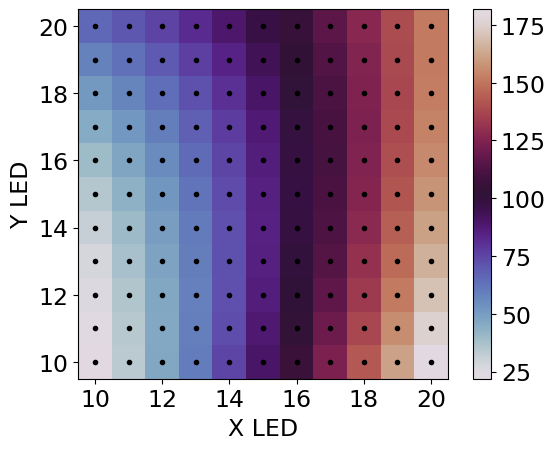

In [20]:
plt.rcParams.update({'font.size': 17})

xticks = np.linspace(10, 20, 6)
yticks = np.linspace(10, 20, 6)

xticklabels = ['', '10', '', '', '', '12', '', '', '', '14', '', '', 
               '', '16', '', '', '', '18', '', '', '', '20', '', '']
yticklabels = ['10', '12', '14', '16', '18', '20']

ang_opt = np.zeros([11, 11])

for x in range(10, 21):
    for y in range(10, 21):
        ang_opt[x-10, y-10] = angle_fn((x, y), OPT_PARAMS_ANGLES).detach().numpy()*180/3.14

fig = plt.figure()

xx, yy = np.meshgrid([i for i in range(10, 21)], [i for i in range(10, 21)])

cp = plt.imshow(np.array([list(reversed(ang_opt[i, :])) for i in range(ang_opt.shape[0])]).T, interpolation='none',
                  extent=[9.5, 20.5, 9.5, 20.5],
                  cmap='twilight'
                 )

plt.grid()
plt.scatter(xx, yy, marker=".", color="black")
# plt.title("Angles")
plt.xlabel('X LED')
plt.ylabel('Y LED')

plt.xticks(xticks)
plt.yticks(yticks)

# someX, someY = 12, 12
# ax = plt.gca()
# ax.add_patch(Rectangle((someX, someY), 7, 7, facecolor="none", ec='red', lw=2))
plt.grid(False)
fig.colorbar(cp)

## Flattening 
$f = \frac{a - b}{a}$

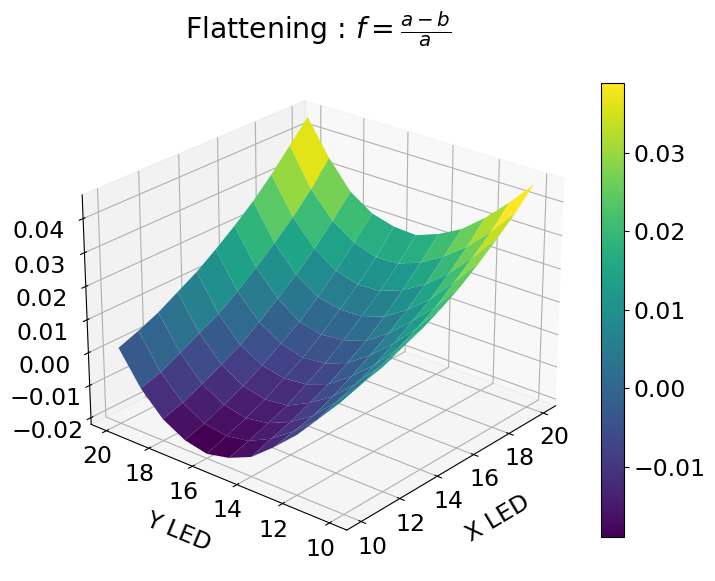

In [21]:
plt.rcParams.update({'font.size': 17})

xticks = np.linspace(10, 20, 6)
yticks = np.linspace(10, 20, 6)
# zticks = np.linspace(2500, 2700, 5)

axis_lens_opt = np.zeros([11, 11, 2])

for x in range(10, 21):
    for y in range(10, 21):
        axis_lens_opt[x-10, y-10, 0] = int(axis_min_fn((x, y), OPT_PARAMS_AXIS[0]).numpy())
        axis_lens_opt[x-10, y-10, 1] = int(axis_max_fn((x, y), OPT_PARAMS_AXIS[1]).numpy())


axis_lens_opt = np.array([list((axis_lens_opt[i, :])) for i in range(axis_lens_opt.shape[0])]).T
xx, yy = np.meshgrid([i for i in range(10, 21)], [i for i in range(10, 21)])

# plt.figaspect(0.5)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')

flattening = (axis_lens_opt[1, :, :] - axis_lens_opt[0, :, :])/axis_lens_opt[1, :, :]
cp = ax.plot_surface(yy, xx, flattening, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', 
                # vmax=2700, vmin=2500
                )
# ax.set_title('Major Axis Lengths');
ax.set_xlabel('X LED')
ax.set_ylabel('Y LED')
# ax.set_zticks(zticks)
ax.view_init(25, -140)

ax.set_xlabel('X LED', labelpad=10)
ax.set_ylabel('Y LED', labelpad=10)
# ax.set_zlabel('Length', labelpad=20)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
# ax.set_zticks(zticks)

ax.tick_params(axis='z', which='major', pad=10)
ax.tick_params(axis='x', which='major', pad=0)
ax.tick_params(axis='y', which='major', pad=0)

fig.colorbar(cp, fraction=0.04, pad=0.04)
plt.title(r'Flattening : $f = \frac{a-b}{a}$')
plt.tight_layout()

## W/o Linear Components

In [22]:
non_linear_coeffs_axis = OPT_PARAMS_AXIS.clone().numpy()
non_linear_coeffs_axis[:, 1:3] = 0.
non_linear_coeffs_axis

array([[ 2.4996e+03,  0.0000e+00,  0.0000e+00,  2.8864e+00, -3.2558e-02,
        -2.2786e-02, -1.2529e-01, -1.3723e-02,  0.0000e+00,  0.0000e+00],
       [ 2.7655e+03,  0.0000e+00,  0.0000e+00,  3.6593e-03, -2.1213e-03,
         2.5728e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],
      dtype=float32)

(11, 11, 2)


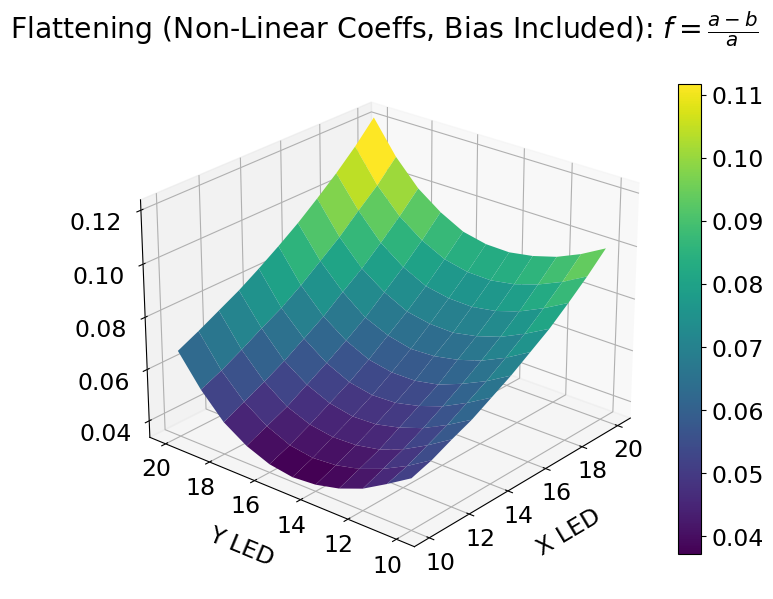

In [23]:
plt.rcParams.update({'font.size': 17})

xticks = np.linspace(10, 20, 6)
yticks = np.linspace(10, 20, 6)
# zticks = np.linspace(2500, 2700, 5)

axis_lens_opt = np.zeros([11, 11, 2])

for x in range(10, 21):
    for y in range(10, 21):
        axis_lens_opt[x-10, y-10, 0] = int(axis_min_fn((x, y), non_linear_coeffs_axis[0]))
        axis_lens_opt[x-10, y-10, 1] = int(axis_max_fn((x, y), non_linear_coeffs_axis[1]))

print(axis_lens_opt.shape)

axis_lens_opt = np.array([list((axis_lens_opt[i, :])) for i in range(axis_lens_opt.shape[0])]).T
xx, yy = np.meshgrid([i for i in range(10, 21)], [i for i in range(10, 21)])

# plt.figaspect(0.5)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')

flattening = (axis_lens_opt[1, :, :] - axis_lens_opt[0, :, :])/(axis_lens_opt[1, :, :] + 0.)
cp = ax.plot_surface(yy, xx, flattening, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', 
                # vmax=2700, vmin=2500
                )
# ax.set_title('Major Axis Lengths');
ax.set_xlabel('X LED')
ax.set_ylabel('Y LED')
# ax.set_zticks(zticks)
ax.view_init(25, -140)

ax.set_xlabel('X LED', labelpad=10)
ax.set_ylabel('Y LED', labelpad=10)
# ax.set_zlabel('Length', labelpad=20)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
# ax.set_zticks(zticks)

ax.tick_params(axis='z', which='major', pad=10)
ax.tick_params(axis='x', which='major', pad=0)
ax.tick_params(axis='y', which='major', pad=0)

fig.colorbar(cp, fraction=0.04, pad=0.04)
plt.title(r'Flattening (Non-Linear Coeffs, Bias Included): $f = \frac{a-b}{a}$')
plt.tight_layout()

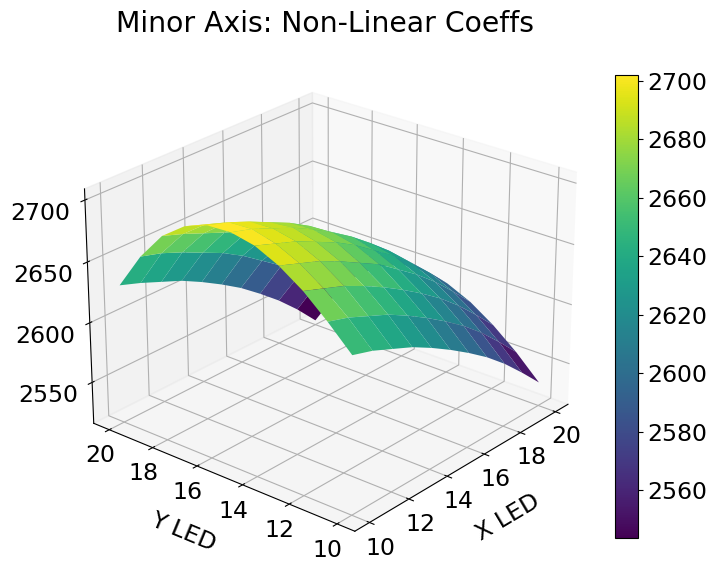

In [24]:
plt.rcParams.update({'font.size': 17})

xticks = np.linspace(10, 20, 6)
yticks = np.linspace(10, 20, 6)
# zticks = np.linspace(2500, 2700, 5)

xx, yy = np.meshgrid([i for i in range(10, 21)], [i for i in range(10, 21)])

# plt.figaspect(0.5)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')

cp = ax.plot_surface(yy, xx, axis_lens_opt[0], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', 
                # vmax=2700, vmin=2500
                )
# ax.set_title('Major Axis Lengths');
ax.set_xlabel('X LED')
ax.set_ylabel('Y LED')
# ax.set_zticks(zticks)
ax.view_init(25, -140)

ax.set_xlabel('X LED', labelpad=10)
ax.set_ylabel('Y LED', labelpad=10)
# ax.set_zlabel('Length', labelpad=20)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
# ax.set_zticks(zticks)

ax.tick_params(axis='z', which='major', pad=10)
ax.tick_params(axis='x', which='major', pad=0)
ax.tick_params(axis='y', which='major', pad=0)

fig.colorbar(cp, fraction=0.04, pad=0.04)
plt.title('Minor Axis: Non-Linear Coeffs')
plt.tight_layout()

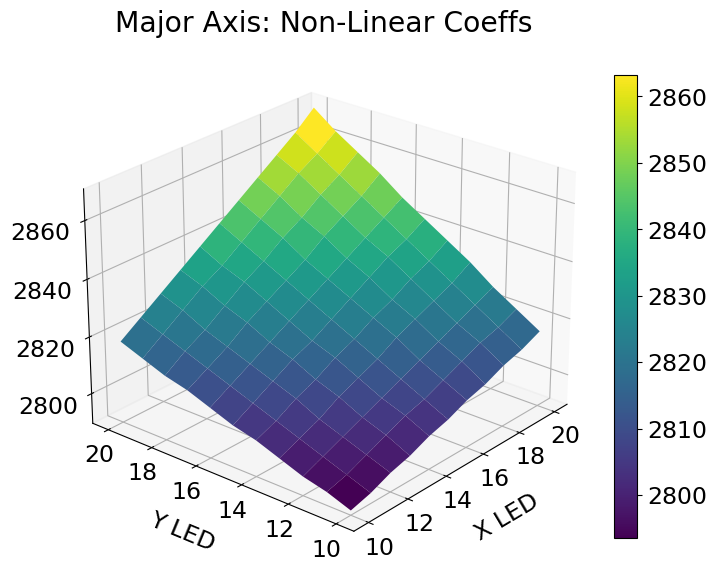

In [25]:
plt.rcParams.update({'font.size': 17})

xticks = np.linspace(10, 20, 6)
yticks = np.linspace(10, 20, 6)
# zticks = np.linspace(2500, 2700, 5)

xx, yy = np.meshgrid([i for i in range(10, 21)], [i for i in range(10, 21)])

# plt.figaspect(0.5)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')

cp = ax.plot_surface(yy, xx, axis_lens_opt[1], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', 
                # vmax=2700, vmin=2500
                )
# ax.set_title('Major Axis Lengths');
ax.set_xlabel('X LED')
ax.set_ylabel('Y LED')
# ax.set_zticks(zticks)
ax.view_init(25, -140)

ax.set_xlabel('X LED', labelpad=10)
ax.set_ylabel('Y LED', labelpad=10)
# ax.set_zlabel('Length', labelpad=20)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
# ax.set_zticks(zticks)

ax.tick_params(axis='z', which='major', pad=10)
ax.tick_params(axis='x', which='major', pad=0)
ax.tick_params(axis='y', which='major', pad=0)

fig.colorbar(cp, fraction=0.04, pad=0.04)
plt.title('Major Axis: Non-Linear Coeffs')
plt.tight_layout()

In [26]:
axis_lens_opt = np.zeros([11, 11, 2])

for x in range(10, 21):
    for y in range(10, 21):
        axis_lens_opt[x-10, y-10, 0] = int(axis_min_fn((x, y), OPT_PARAMS_AXIS[0]).numpy())
        axis_lens_opt[x-10, y-10, 1] = int(axis_max_fn((x, y), OPT_PARAMS_AXIS[1]).numpy())

X, Y = np.meshgrid([i for i in range(10, 21)], [i for i in range(10, 21)])

In [27]:
A = np.array([X.reshape(-1), Y.reshape(-1), np.ones(X.size)]).T

In [28]:
axis_linear = np.matmul(np.matmul(np.linalg.pinv(np.matmul(A.T, A)), A.T), axis_lens_opt.reshape(121, 2))

In [29]:
axis_linear

array([[-1.07801653e+01, -6.14049587e-01],
       [-3.68595041e-01, -2.88181818e+00],
       [ 2.80346281e+03,  2.70673554e+03]])

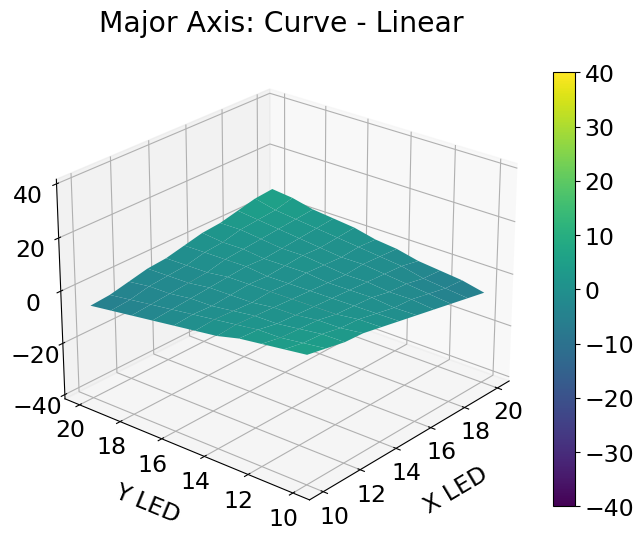

In [43]:
plt.rcParams.update({'font.size': 17})

xticks = np.linspace(10, 20, 6)
yticks = np.linspace(10, 20, 6)
zticks = np.linspace(-40, 40, 5)

axis_linear_opt = np.zeros([11, 11, 2])
X, Y = np.meshgrid([i for i in range(10, 21)], [i for i in range(10, 21)])
axis_linear_opt[:, : , 0] = axis_linear[0, 0]*X + axis_linear[1, 0]*Y + axis_linear[2, 0]
axis_linear_opt[:, : , 1] = axis_linear[0, 1]*X + axis_linear[1, 1]*Y + axis_linear[2, 1]

axis_linear_opt = np.array([list((axis_linear_opt[i, :])) for i in range(axis_linear_opt.shape[0])]).T

axis_lens_opt = np.zeros([11, 11, 2])

for x in range(10, 21):
    for y in range(10, 21):
        axis_lens_opt[x-10, y-10, 0] = int(axis_min_fn((x, y), OPT_PARAMS_AXIS[0]).numpy())
        axis_lens_opt[x-10, y-10, 1] = int(axis_max_fn((x, y), OPT_PARAMS_AXIS[1]).numpy())

axis_lens_opt = np.array([list((axis_lens_opt[i, :])) for i in range(axis_lens_opt.shape[0])]).T
xx, yy = np.meshgrid([i for i in range(10, 21)], [i for i in range(10, 21)])

# plt.figaspect(0.5)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')

cp = ax.plot_surface(yy, xx, axis_lens_opt[1, :, :] - axis_linear_opt[1, :, :], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', 
                vmax=40, vmin=-40
                )
# ax.set_title('Major Axis Lengths');
ax.set_xlabel('X LED')
ax.set_ylabel('Y LED');
# ax.set_zticks(zticks)
ax.view_init(25, -140)

ax.set_xlabel('X LED', labelpad=10)
ax.set_ylabel('Y LED', labelpad=10)
# ax.set_zlabel('Length', labelpad=20)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_zticks(zticks)

# ax.tick_params(axis='z', which='major', pad=10)
ax.tick_params(axis='x', which='major', pad=0)
ax.tick_params(axis='y', which='major', pad=0)

plt.title('Major Axis: Curve - Linear')
fig.colorbar(cp, fraction=0.04, pad=0.04)
# plt.tight_layout()

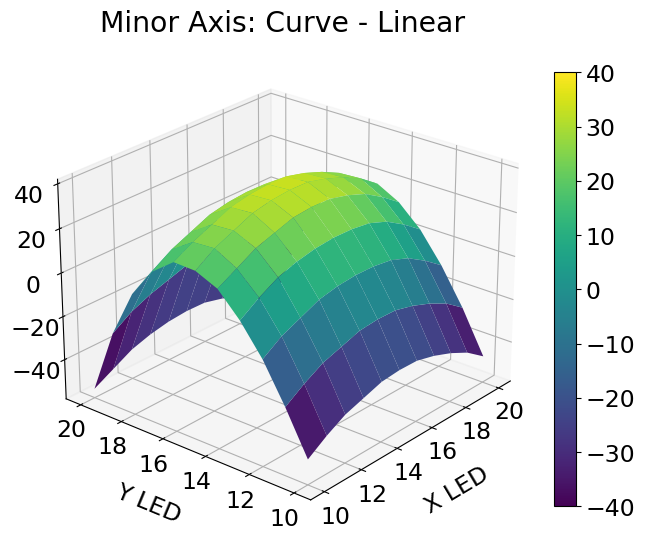

In [42]:
plt.rcParams.update({'font.size': 17})

xticks = np.linspace(10, 20, 6)
yticks = np.linspace(10, 20, 6)
zticks = np.linspace(-40, 40, 5)

axis_linear_opt = np.zeros([11, 11, 2])
X, Y = np.meshgrid([i for i in range(10, 21)], [i for i in range(10, 21)])
axis_linear_opt[:, : , 0] = axis_linear[0, 0]*X + axis_linear[1, 0]*Y + axis_linear[2, 0]
axis_linear_opt[:, : , 1] = axis_linear[0, 1]*X + axis_linear[1, 1]*Y + axis_linear[2, 1]

axis_linear_opt = np.array([list((axis_linear_opt[i, :])) for i in range(axis_linear_opt.shape[0])]).T

axis_lens_opt = np.zeros([11, 11, 2])

for x in range(10, 21):
    for y in range(10, 21):
        axis_lens_opt[x-10, y-10, 0] = int(axis_min_fn((x, y), OPT_PARAMS_AXIS[0]).numpy())
        axis_lens_opt[x-10, y-10, 1] = int(axis_max_fn((x, y), OPT_PARAMS_AXIS[1]).numpy())

axis_lens_opt = np.array([list((axis_lens_opt[i, :])) for i in range(axis_lens_opt.shape[0])]).T
xx, yy = np.meshgrid([i for i in range(10, 21)], [i for i in range(10, 21)])

# plt.figaspect(0.5)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')

cp = ax.plot_surface(yy, xx, axis_lens_opt[0, :, :] - axis_linear_opt[0, :, :], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', 
                vmax=40, vmin=-40
                )
# ax.set_title('Major Axis Lengths');
ax.set_xlabel('X LED')
ax.set_ylabel('Y LED');
# ax.set_zticks(zticks)
ax.view_init(25, -140)

ax.set_xlabel('X LED', labelpad=10)
ax.set_ylabel('Y LED', labelpad=10)
# ax.set_zlabel('Length', labelpad=20)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_zticks(zticks)

# ax.tick_params(axis='z', which='major', pad=10)
ax.tick_params(axis='x', which='major', pad=0)
ax.tick_params(axis='y', which='major', pad=0)

plt.title('Minor Axis: Curve - Linear')
fig.colorbar(cp, fraction=0.04, pad=0.04)
# plt.tight_layout()

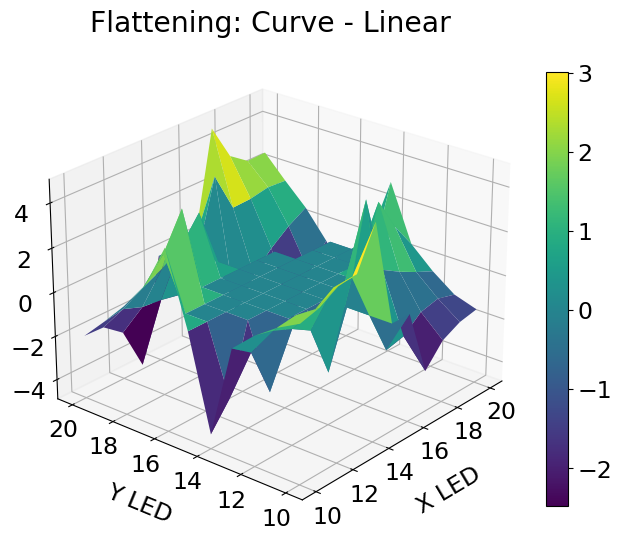

In [32]:
plt.rcParams.update({'font.size': 17})

xticks = np.linspace(10, 20, 6)
yticks = np.linspace(10, 20, 6)
# zticks = np.linspace(2500, 2700, 5)

axis_linear_opt = np.zeros([11, 11, 2])

axis_linear_opt[:, : , 0] = axis_linear[0, 0]*X + axis_linear[1, 0]*Y + axis_linear[2, 0]
axis_linear_opt[:, : , 1] = axis_linear[0, 1]*X + axis_linear[1, 1]*Y + axis_linear[2, 1]

axis_linear_opt = np.array([list((axis_linear_opt[i, :])) for i in range(axis_linear_opt.shape[0])]).T

axis_lens_opt = np.zeros([11, 11, 2])

for x in range(10, 21):
    for y in range(10, 21):
        axis_lens_opt[x-10, y-10, 0] = int(axis_min_fn((x, y), OPT_PARAMS_AXIS[0]).numpy())
        axis_lens_opt[x-10, y-10, 1] = int(axis_max_fn((x, y), OPT_PARAMS_AXIS[1]).numpy())

axis_lens_opt = np.array([list((axis_lens_opt[i, :])) for i in range(axis_lens_opt.shape[0])]).T

curve_minus_linear = axis_lens_opt - axis_linear_opt
flattening = (curve_minus_linear[1]/2 - curve_minus_linear[0]/2)/curve_minus_linear[1]/2
flattening[np.abs(flattening) > 5] = 0.

xx, yy = np.meshgrid([i for i in range(10, 21)], [i for i in range(10, 21)])

# plt.figaspect(0.5)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')

cp = ax.plot_surface(yy, xx, flattening, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', 
                # vmax=5, vmin=-5
                )
# ax.set_title('Major Axis Lengths');
ax.set_xlabel('X LED')
ax.set_ylabel('Y LED');
# ax.set_zticks(zticks)
ax.view_init(25, -140)

ax.set_xlabel('X LED', labelpad=10)
ax.set_ylabel('Y LED', labelpad=10)
# ax.set_zlabel('Length', labelpad=20)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
# ax.set_zticks(zticks)

# ax.tick_params(axis='z', which='major', pad=10)
ax.tick_params(axis='x', which='major', pad=0)
ax.tick_params(axis='y', which='major', pad=0)

plt.title('Flattening: Curve - Linear ')
fig.colorbar(cp, fraction=0.04, pad=0.04)
# plt.tight_layout()

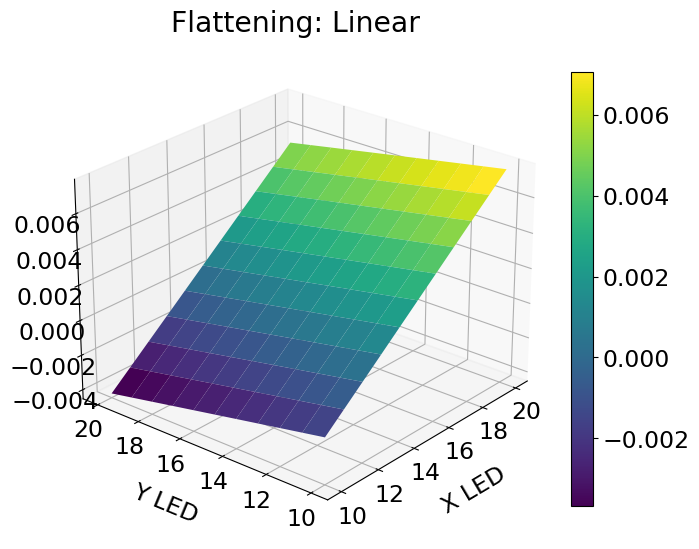

In [33]:
plt.rcParams.update({'font.size': 17})

xticks = np.linspace(10, 20, 6)
yticks = np.linspace(10, 20, 6)
# zticks = np.linspace(2500, 2700, 5)

axis_linear_opt = np.zeros([11, 11, 2])

axis_linear_opt[:, : , 0] = axis_linear[0, 0]*X + axis_linear[1, 0]*Y + axis_linear[2, 0]
axis_linear_opt[:, : , 1] = axis_linear[0, 1]*X + axis_linear[1, 1]*Y + axis_linear[2, 1]

axis_linear_opt = np.array([list((axis_linear_opt[i, :])) for i in range(axis_linear_opt.shape[0])]).T


flattening = (axis_linear_opt[1]/2 - axis_linear_opt[0]/2)/axis_linear_opt[1]/2

xx, yy = np.meshgrid([i for i in range(10, 21)], [i for i in range(10, 21)])

# plt.figaspect(0.5)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')

cp = ax.plot_surface(yy, xx, flattening, rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', 
                # vmax=5, vmin=-5
                )
# ax.set_title('Major Axis Lengths');
ax.set_xlabel('X LED')
ax.set_ylabel('Y LED');
# ax.set_zticks(zticks)
ax.view_init(25, -140)

ax.set_xlabel('X LED', labelpad=10)
ax.set_ylabel('Y LED', labelpad=10)
# ax.set_zlabel('Length', labelpad=20)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
# ax.set_zticks(zticks)

# ax.tick_params(axis='z', which='major', pad=10)
ax.tick_params(axis='x', which='major', pad=0)
ax.tick_params(axis='y', which='major', pad=0)

plt.title('Flattening: Linear ')
fig.colorbar(cp, fraction=0.04, pad=0.04)
# plt.tight_layout()

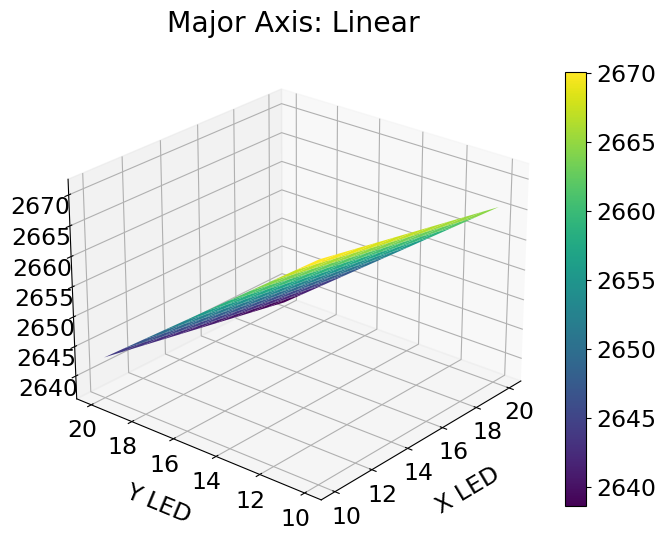

In [34]:
plt.rcParams.update({'font.size': 17})

xticks = np.linspace(10, 20, 6)
yticks = np.linspace(10, 20, 6)
# zticks = np.linspace(2500, 2700, 5)

axis_linear_opt = np.zeros([11, 11, 2])

axis_linear_opt[:, : , 0] = axis_linear[0, 0]*X + axis_linear[1, 0]*Y + axis_linear[2, 0]
axis_linear_opt[:, : , 1] = axis_linear[0, 1]*X + axis_linear[1, 1]*Y + axis_linear[2, 1]

axis_linear_opt = np.array([list((axis_linear_opt[i, :])) for i in range(axis_linear_opt.shape[0])]).T
xx, yy = np.meshgrid([i for i in range(10, 21)], [i for i in range(10, 21)])

# plt.figaspect(0.5)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')

cp = ax.plot_surface(yy, xx, axis_linear_opt[1, :, :], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', 
                # vmax=2700, vmin=2500
                )
# ax.set_title('Major Axis Lengths');
ax.set_xlabel('X LED')
ax.set_ylabel('Y LED');
# ax.set_zticks(zticks)
ax.view_init(25, -140)

ax.set_xlabel('X LED', labelpad=10)
ax.set_ylabel('Y LED', labelpad=10)
# ax.set_zlabel('Length', labelpad=20)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
# ax.set_zticks(zticks)

# ax.tick_params(axis='z', which='major', pad=10)
ax.tick_params(axis='x', which='major', pad=0)
ax.tick_params(axis='y', which='major', pad=0)

plt.title('Major Axis: Linear')
fig.colorbar(cp, fraction=0.04, pad=0.04)
# plt.tight_layout()

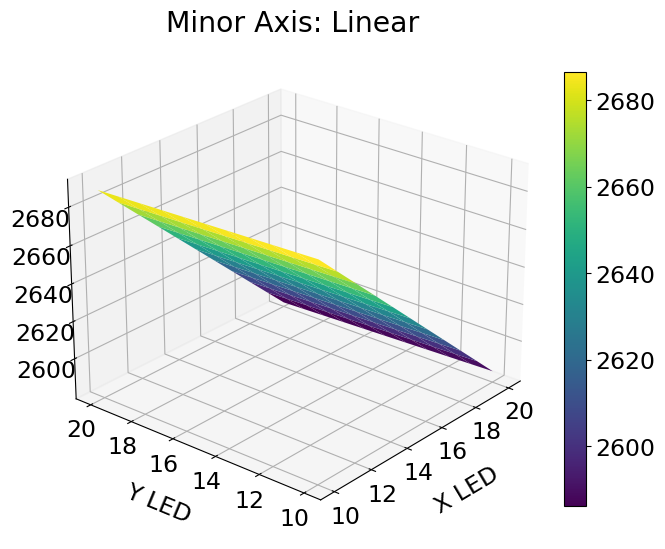

In [35]:
plt.rcParams.update({'font.size': 17})

xticks = np.linspace(10, 20, 6)
yticks = np.linspace(10, 20, 6)
# zticks = np.linspace(2500, 2700, 5)

# plt.figaspect(0.5)
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(1, 1, 1, projection='3d')

cp = ax.plot_surface(yy, xx, axis_linear_opt[0, :, :], rstride=1, cstride=1,
                cmap='viridis', edgecolor='none', 
                # vmax=2700, vmin=2500
                )
# ax.set_title('Major Axis Lengths');
ax.set_xlabel('X LED')
ax.set_ylabel('Y LED');
# ax.set_zticks(zticks)
ax.view_init(25, -140)

ax.set_xlabel('X LED', labelpad=10)
ax.set_ylabel('Y LED', labelpad=10)
# ax.set_zlabel('Length', labelpad=20)

ax.set_xticks(xticks)
ax.set_yticks(yticks)
# ax.set_zticks(zticks)

# ax.tick_params(axis='z', which='major', pad=10)
ax.tick_params(axis='x', which='major', pad=0)
ax.tick_params(axis='y', which='major', pad=0)

plt.title('Minor Axis: Linear')
fig.colorbar(cp, fraction=0.04, pad=0.04)
# plt.tight_layout()